# Tutorial 0d: A sample homework problem

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">



*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](t0d_sample_homework_problem.ipynb).*

In [1]:
import copy
import logging

import numpy as np
import pandas as pd
import scipy.stats as st
import pystan

import bebi103
import altair_catplot as altcat

import altair as alt

try:
    import datashader
except:
    pass

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

To give you an idea of what we would like in your homework responses, I show in this tutorial with an short homework problem.  The problem has both a theoretical part and a practical part to demonstrate how we would like each done.  It is important to show and discuss all reasoning and code that goes into the solution.

A quick note: Don't freak out that you don't understand everything in this problem. You almost certainly will not at the beginning of the course, but you will by the end.  This is just to show what kinds of solutions we expect on the homework.

### Example problem 0.1 (Heritability and finch beaks)

Peter and Rosemary Grant have been working on the Galápagos island of Daphne for over forty years.  During this time, they have collected lots and lots of data about physiological features of finches.  They published a book with a summary of some of their major results (Grant P. R., Grant B. R., *Data from: 40 years of evolution. Darwin's finches on Daphne Major Island*, Princeton University Press, 2014). They made their data from the book publicly available via the [Dryad Digital Repository](http://dx.doi.org/10.5061/dryad.g6g3h).

In this problem, we will investigate their data on the heritability of beak depth (the distance, top to bottom, of a closed beak) in the ground finch *Geospiza fortis*.  The data set consists of the maternal beak depth, the paternal beak depth, and the mean beak depth of their offspring.  You can download the data set, which I got from Dryad and tidied up into a CSV file, [here](../data/grant_and_grant.csv).

**a)** The **narrow sense heritability**, denoted $h^2$, of a trait is defined as the ratio of the additive genetic variance in offspring to the total phenotypic variance in the parent.  The additive genetic variance of a population describes the variability in a trait resulting from the sum of all effects of the alleles.  In other words, $h^2$ is the ratio of the parent-offspring covariance in the trait value to the variance in the parents.

\begin{align}
h^2 = \frac{\sigma_{po}}{\sigma_p^2},
\end{align}

where the subscripts $o$ and $p$ indicate offspring and parents, respectively.

In practice, $h^2$ is often computed by plotting the average beak depth of the offspring against the average beak depth of the two parents, and then preforming a linear least squares regression, with $h^2$ being given by the slope. Show that this gives $h^2$ as we have defined it. (Think about what people mean when they say "perform a linear regression." What are their priors? This is in some ways an exercise in trying to understand what people mean when the describe their methods with inadequate detail to reproduce it without guesswork, which happens all too often.)

*Note*: in this analysis, we are neglecting confounding issues and just assuming the environment is unchanging and that the mean trait values we are using for the parents and the offspring is indicative of the differences.

**b)** Provide an estimate for the heritability of beak depth with a confidence interval.

**c)** In choosing to do a linear regression, we tacitly assume a statistical model where there is no error at all in the measurement of beak depth (the x-axis), and homoscedastic errors in the beak length (the y-axis). Since both are measured in a similar way, this is not really a good generative statistical model. Instead propose a generative model and perform a parameter estimate for the heritability using that model.

### Example problem 0.1 solution

**a)** We are first asked to prove that $h^2$ is the slope of a linear regression line between of the plot of parental beak depth versus offspring beak depth. First, we have to try to ascertain what is meant by a "linear regression line." When stated this way, this usually means that the regression is performed by assuming an improper Uniform prior for the slope and intercept parameters and a Gaussian likelihood with homoscedastic error. The prior on this homoscedastic error is also improper Uniform. The reported values of the slope and intercept are the most probable, or the MAP. So, let's proceed with these assumptions. Beginning with Bayes's theorem, 

\begin{align}
g(m, b, \sigma \mid D) = \frac{f(D\mid m, b, \sigma)\,g(m, b, \sigma)}{f(D)}.
\end{align}

We assume the data follow $y = mx + b$ and that the errors are Gaussian distributed, all with the same standard deviation, $\sigma$ (i.e., we assume homoscedastic error).  This gives a likelihood of

\begin{align}
f(D\mid m, b, \sigma) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left\{-\frac{(y_i - m x_i - b)^2}{2\sigma^2}\right\}.
\end{align}

Assuming Uniform priors, we have

\begin{align}
g(m, b, \sigma) = \text{constant}.
\end{align}

The log posterior is then

\begin{align}
\ln g(m, b, \sigma \mid D) \propto -n \ln \sigma - \frac{1}{2\sigma^2}\sum_{i\in D} \left(y_i - m x_i - b\right)^2,
\end{align}

where $n = |D|$.

To find the most probable slope and intercept, we differentiate the log posterior and find where the gradient is zero.

\begin{align}
\frac{\partial}{\partial m}\,\ln g(m, b, \sigma \mid D) 
&= \frac{1}{\sigma^2}\sum_{i\in D} \left( y_i - m x_i - b\right)x_i = 0, \\[1em]
\frac{\partial}{\partial b}\,\ln g(m, b, \sigma \mid D)
&= \frac{1}{\sigma^2}\sum_{i\in D} \left( y_i - m x_i - b\right) = 0.
\end{align}

We can multiply the each equation by $\sigma^2/n$ to get

\begin{align}
\frac{1}{n}\sum_{i\in D} \left( y_i - m x_i - b\right)x_i = \langle xy \rangle - m\langle x^2 \rangle - b\langle x \rangle &= 0,\\[1em]
\frac{1}{n}\sum_{i\in D} \left( y_i - m x_i - b\right) = \langle y\rangle - m\langle x\rangle - b &= 0.
\end{align}

We solve the bottom equation for $b$

\begin{align}
b = \langle y \rangle - m \langle x \rangle,
\end{align}

which we then insert into the top equation, giving

\begin{align}
\langle xy \rangle - m\langle x^2 \rangle - \left(\langle y \rangle - m \langle x\right\rangle)\langle x \rangle &= 0.
\end{align}

This can be rearranged to give

\begin{align}
m = \frac{\langle xy \rangle - \langle x \rangle\langle y\rangle}{\left\langle x^2 - \langle x \rangle^2\right\rangle}.
\end{align}

We recognize the numerator as the sample covariance between $x$ and $y$ and the denominator as the sample variance of $x$. Thus, we have proven what we set out to prove.

**b)** We start by loading in the data set and adjusting column headings for convenience.

In [2]:
# Read data
df = pd.read_csv('../data/grant_and_grant_2014.csv')

# Rename columns
df = df.rename(columns={'Mid-offspr': 'offspring_bd', 
                        'Male BD': 'male_bd', 
                        'Female BD': 'female_bd'})

We will need the mean parental beak depth for to compute the heritabilty, as per its definition, so we create a new column in the `DataFrame` that has that.

In [3]:
# Make a new column with the mean of the male and female parent columns
df['parent_bd'] = (df['male_bd'] + df['female_bd']) / 2

We'll first plot the data to see what we are dealing with.

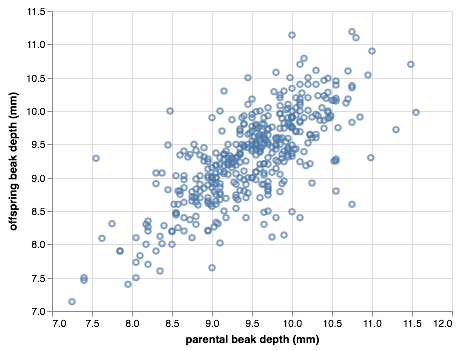

In [4]:
alt.Chart(df
    ).mark_point(
    ).encode(
        x=alt.X('parent_bd:Q', 
                scale=alt.Scale(zero=False),
                title='parental beak depth (mm)'),
        y=alt.Y('offspring_bd:Q', 
                scale=alt.Scale(zero=False),
                title='offspring beak depth (mm)'),
    )

We can get a point estimate of the heritability by directly computing it from the sample variances of the data set. Since we will draw bootstrap samples momentarily, we should write a function to compute the heritability.

In [5]:
def heritability(parent_bd, offspring_bd):
    cov = np.cov(parent_bd, offspring_bd)
    return cov[0, 1] / cov[0, 0]

The point estimate is then easily computed.

In [6]:
point_estimate_h2 = heritability(df['parent_bd'], df['offspring_bd'])

point_estimate_h2

0.7229051911438156

Now, to compute the confidence interval, we will perform a pairs bootstrap calculation. For speed, we will first slice out the parental and offspring beak depths as NumPy arrays.

In [7]:
parent_bd = df['parent_bd'].values
offspring_bd = df['offspring_bd'].values

def draw_bs_reps(parent_bd, offspring_bd, size=1):
    inds = np.arange(len(parent_bd))
    reps = np.empty(size)
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        reps[i] = heritability(parent_bd[bs_inds], offspring_bd[bs_inds])
    return reps
    
# Draw reps
bs_reps = draw_bs_reps(parent_bd, offspring_bd, size=10000)

# 95% onfidence interval
np.percentile(bs_reps, [2.5, 97.5])

array([0.64508129, 0.79707504])

With our point estimate and confidence interval, we can report the heritability and the 95% confidence interval as $h^2 = 0.72^{+0.08}_{-0.07}$.

**c)** We will first specify a generative model for the beak depths for parents and offspring. In the modeling, we assume that the variability in beak depth from bird to bird is far greater than the measurement error, so we neglect the measurement error. We further assume that trait heredity is directly related to the mean of the parental trait.

#### Construction of the generative model

We begin constructing our generative model by writing down the likelihood. 

We will assume that the mean beak depth of the offspring of a parental pair is related to the mean beak depth of the mother and father via a bivariate Gaussian. We will assume that the mean beak depth of the parents and the offspring of the population are the same, meaning that the average beak depth of the whole population is not going to change appreciably in one generation. We make the same assumptions for the variance in beak depth (but obviously not the covariance). We define this mean as $\mu$ and define $\boldsymbol{\mu} = (\mu, \mu)^T$ for convenience. The covariance of the bivariate Gaussian is

\begin{align}
\mathsf{\Sigma} = \begin{pmatrix}
\sigma & \sigma_{po} \\
\sigma_{po} & \sigma
\end{pmatrix},
\end{align}

where the subscripts $p$ and $o$ denote respectively parents and offspring. Thus, the likelihood for a single parent/offspring beak depth pair, $\mathbf{d} = (d_p, d_o)^T$ is

\begin{align}
f(\mathbf{d}\mid\boldsymbol{\mu},\mathsf{\Sigma}) = \frac{1}{\sqrt{2\pi\,\mathrm{det}(\mathsf{\Sigma})}}\,\exp\left[\frac{1}{2}(\mathbf{d}-\boldsymbol{\mu})^T\cdot\mathsf{\Sigma}^{-1}\cdot(\mathbf{d}-\boldsymbol{\mu})\right].
\end{align}

Taking all the data sets together, we have
\begin{align}
f(D\mid\boldsymbol{\mu},\mathsf{\Sigma}) = \left(2\pi\,\mathrm{det}(\mathsf{\Sigma})\right)^{-n/2}\,\exp\left[\frac{1}{2}\sum_{\mathbf{d}_i\in D}(\mathbf{d}_i-\boldsymbol{\mu})^T\cdot\mathsf{\Sigma}^{-1}\cdot(\mathbf{d}_i-\boldsymbol{\mu})\right].
\end{align}

Written succinctly, this is
\begin{align}
d_{p,i}, d_{o,i} \mid \boldsymbol{\mu}, \mathsf{\Sigma} \sim \text{MultiNormal}(\boldsymbol{\mu}, \mathsf{\Sigma})\;\;\forall i.
\end{align}

We therefore need to specify priors for $\boldsymbol{\mu}$ and $\mathsf{\Sigma}$, which is in effect a prior for three parameters, $\mu$, $\sigma$, and $\sigma_{po}$. The latter two parameters are constrained by the fact that $\mathsf{\Sigma}$ must be positive definite.

We will take $\mu$ to have a Normal distribution around 10 mm, which seems a reasonable depth for a finch beak.

\begin{align}
\mu \sim \text{Normal}(10, 3).
\end{align}


The prior for $\mathsf{\Sigma}$ is trickier because of the positive definiteness constraint. Recall that we can re-write $\mathsf{\Sigma}$ in terms of the standard deviations of each variable, which are in this case the same, giving $\boldsymbol{\sigma} = (\sigma, \sigma)^T$, and the correlation matrix $\mathsf{\Omega}$. 

\begin{align}
\mathsf{\Sigma} = \mathrm{diag}(\boldsymbol{\sigma}) \cdot \mathsf{\Omega} \cdot \mathrm{diag}(\boldsymbol{\sigma}),
\end{align}

Recall that in general, if matrices $\mathsf{A}$ and $\mathsf{B}$ are positive definite, then $\mathsf{A}\cdot\mathsf{B}\cdot\mathsf{A}$ is positive definite. Because the diagonal standard deviation matrices are positive definite, the covariance matrix $\mathsf{\Sigma}$ is positive definite if the correlation matrix $\mathsf{\Omega}$ is positive definite. So, we will use an **LKJ prior** [(Lewandowski, Kurowicka, and Joe)](https://doi.org/10.1016/j.jmva.2009.04.008) for the correlation matrix to ensure positive definiteness. We will to specify that the LKJ parameter $\eta = 1$, meaning that we are unsure if we will see heredity or anti-heredity. So, we complete the prior specification as

\begin{align}
&\sigma \sim \text{HalfNormal}(2),\\[1em]
&\mathsf{\Omega} \sim \text{LKJ}(1).
\end{align}

We will use the Cholesky formulation of the covariance matrix. Let's build a Stan model. We'll compile it and then check out the code.

In [8]:
sm_prior_generative = bebi103.stan.StanModel('t0d_finch_beaks_prior_generative_v01.stan')
print('\n', sm_prior_generative.model_code)

Using cached StanModel.

 functions {
  real heritability(real[] parent, real[] offspring) {
    real parent_var = variance(parent);
    real parent_mean = mean(parent);
    real offspring_mean = mean(offspring);
    int n = size(parent);

    real covariance = 0.0;
    for (i in 1:size(parent)) {
      covariance +=   (parent[i] - parent_mean) 
                    * (offspring[i] - offspring_mean) / n;
    }

    return covariance / parent_var;
  }
}


data {
  // Parameters for priors
  real mu_mean;
  real mu_std;
  real sigma_std;
  real eta;

  // Size of data set
  int<lower=1> N;
}


generated quantities {
  // Means and variances of univariates
  real mu = normal_rng(mu_mean, mu_std);
  real<lower=0> sigma = fabs(normal_rng(0.0, sigma_std));

  // Declare covariance matrix and cholesky variable; want to keep these
  matrix[2, 2] covariance_matrix;
  cholesky_factor_corr[2] L_Omega = lkj_corr_cholesky_rng(2, eta);

  // Heredity
  real heredity_parameter = L_Omega[2, 1];
  real 

Now we'll specify the inputs to the Stan sampler. The "data" for the prior generative distribution are specifications for the prior parameters.

In [9]:
# Data for prior generative distribution
data_prior_gen = dict(N=len(parent_bd),
                      mu_mean=10.0,
                      mu_std=3.0,
                      sigma_std=2.0,
                      eta=1.0)

#### Prior predictive checks

Now we can draw our samples for prior predictive checks. This is important to make sure that our prior is well-specified. If we get data sets that are unreasonable, we need to revisit the prior specification. Specifically, we will make ECDFs of the parental and offspring beak depths.

In [10]:
prior_check_samples = sm_prior_generative.sampling(data=data_prior_gen, 
                                                   algorithm='Fixed_param', 
                                                   iter=1000, 
                                                   chains=1, 
                                                   warmup=0)

# Make plots
p1 = bebi103.viz.predictive_ecdf(prior_check_samples, 
                                 'parent_bd', 
                                 x_axis_label='parent beak depth (mm)')
p2 = bebi103.viz.predictive_ecdf(prior_check_samples, 
                                 'offspring_bd',
                                 x_axis_label='offspring beak depth (mm)')

p1.x_range = p2.x_range
bokeh.io.show(bokeh.layouts.gridplot([p1, p2], ncols=2))

/Users/Justin/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [11]:
percentiles = [80, 60, 40, 20]
ptiles = [pt for pt in percentiles if pt > 0]
ptiles = ([50 - pt/2 for pt in percentiles] + [50] 
            + [50 + pt/2 for pt in percentiles][::-1])
for i, ptile in enumerate(ptiles[:len(ptiles)//2]):
    print(ptile, ptiles[-i-1])

10.0 90.0
20.0 80.0
30.0 70.0
40.0 60.0


Here, the light-to-dark shading represent the middle 80th, 60th, 40th, and 20th percentile range, and the line in the middle is the median ECDF. These both seem to look ok, but there are very rare extreme beak depths, including unphysical negative ones. This should not be too big of a problem, though, since it is rare that we see it, and the data set should strongly inform the posterior.

Now let's look at the empirical heritability we obtain from the simulated data.

In [12]:
p = bebi103.viz.ecdf(
    prior_check_samples.extract('empirical_heritability')['empirical_heritability'],
    x_axis_label='heritability')

bokeh.io.show(p)

The heritability is Uniformly distributed on the interval [-1, 1]. This does not seem right; a prior we would expect the heritability to be above zero. We could reparametrize the model directly in terms of the heritability instead of in terms of a positive definite covariance matrix using the LKJ distribution. This is possible because the 2 by 2 covariance matrix is tractable and we can appropriately bound the heritability. We will not take this option because of practical considerations. So, instead, we will make our prior on the heritability to have a nonstandard Beta distribution (like a Beta distribution, but on the interval [-1, 1] in this case. So, our new model has the heritability as a parameter with prior/transformation

\begin{align}
&h_\beta^2 \sim \text{Beta}(5, 2), \\
&h^2 = 2h_\beta^2 - 1.
\end{align}

The covariance matrix for the likelihood is built from the parameter $\sigma$, which we already defined, and $h^2$. We'll make a new version of the Stan model with this included.

In [13]:
sm_prior_generative = bebi103.stan.StanModel('t0d_finch_beaks_prior_generative_v02.stan')
print('\n', sm_prior_generative.model_code)

Using cached StanModel.

 functions {
  real heritability(real[] parent, real[] offspring) {
    real parent_var = variance(parent);
    real parent_mean = mean(parent);
    real offspring_mean = mean(offspring);
    int n = size(parent);

    real covariance = 0.0;
    for (i in 1:size(parent)) {
      covariance +=   (parent[i] - parent_mean) 
                    * (offspring[i] - offspring_mean) / n;
    }

    return covariance / parent_var;
  }
}


data {
  // Parameters for priors
  real mu_mean;
  real mu_std;
  real sigma_std;
  real a;
  real b;

  // Size of data set
  int<lower=1> N;
}


generated quantities {
  // Means and variances of univariates
  real mu = normal_rng(mu_mean, mu_std);
  real<lower=0> sigma = fabs(normal_rng(0.0, sigma_std));

  // Heritability
  real h2_beta = beta_rng(a, b);
  real h2 = 2.0 * h2_beta - 1.0;

  // Build Cholesky decomposition of covariance matrix
  matrix[2, 2] L_Sigma = sigma * [[1.0, 0], 
                                  [h2,  sqrt(1

Of course, we need to update the inputted data for the Stan model to reflect the changes.

In [14]:
# Data for prior generative distribution
data_prior_gen = dict(N=len(parent_bd),
                      mu_mean=10.0,
                      mu_std=3.0,
                      sigma_std=2.0,
                      a=5.0,
                      b=2.0)

We're all set to sample some data sets and plot ECDFs of the resulting parental and offspring beak depths.

In [15]:
prior_check_samples = sm_prior_generative.sampling(data=data_prior_gen, 
                                                   algorithm='Fixed_param', 
                                                   iter=1000, 
                                                   chains=1, 
                                                   warmup=0)

# Make plots
p1 = bebi103.viz.predictive_ecdf(prior_check_samples, 
                                 'parent_bd', 
                                 x_axis_label='parent beak depth (mm)')
p2 = bebi103.viz.predictive_ecdf(prior_check_samples, 
                                 'offspring_bd',
                                 x_axis_label='offspring beak depth (mm)')

p1.x_range = p2.x_range
bokeh.io.show(bokeh.layouts.gridplot([p1, p2], ncols=2))

/Users/Justin/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Those look fine, as before, with the same caveat that we do occasionally get unphysical beak depths, but we're willing to live with this. Let's check the heritability, which was problematic in the first model. 

In [16]:
p = bebi103.viz.ecdf(prior_check_samples.extract('empirical_heritability')['empirical_heritability'],
                     x_axis_label='heritability')
bokeh.io.show(p)

This looks closer to what we might expect. About ninety percent of the data sets show a positive empirical heritability. We conclude that we are happy with this model and move forward to assessing the sampler's performace.

#### Simulation-based calibration

We now perform simulation-based calibration (SBC) to ensure that the sampler can effectively sample the entire space of parameters covered by the prior. First, we'll set up the model and the input data.

In [17]:
# Data for posterior sampling (no PPC necessary for now)
data_post = copy.deepcopy(data_prior_gen)
data_post['parent_bd'] = parent_bd
data_post['offspring_bd'] = offspring_bd
data_post['ppc'] = 0

sm = bebi103.stan.StanModel('t0d_finch_beaks_v02.stan')
print('\n', sm.model_code)

Using cached StanModel.

 data {
  // Parameters for priors
  real mu_mean;
  real mu_std;
  real sigma_std;
  real a;
  real b;

  // Data
  int<lower=1> N;
  real parent_bd[N];
  real offspring_bd[N];

  // Do posterior predictive checks?
  int ppc;
}


transformed data {
  vector[2] beak_depths[N];
  for (i in 1:N) {
    beak_depths[i] = [parent_bd[i], offspring_bd[i]]';
  }
}


parameters {
  real mu;
  real<lower=0> sigma;
  real<lower=0, upper=1> h2_beta;
}


transformed parameters {
  real h2 = 2.0 * h2_beta - 1.0;
  matrix[2, 2] L_Sigma = sigma * [[1.0, 0], 
                                  [h2,  sqrt(1.0 - h2^2)]];  
}


model {
  mu ~ normal(mu_mean, mu_std);
  sigma ~ normal(0.0, sigma_std);
  h2_beta ~ beta(a, b);

  beak_depths ~ multi_normal_cholesky([mu, mu]', L_Sigma);
}


generated quantities {
  // Posterior predictive check
  real parent_bd_ppc[N*ppc];
  real offspring_bd_ppc[N*ppc];

  {
    vector[2] beak_depths_ppc;
    if(ppc) {
      for (i in 1:N) {
        be

Now we can do the SBC. To avoid running these rather long calculations again, we will store the results as a CSV file.

In [18]:
try:
    sbc_output = pd.read_csv('sbc_output_v02.csv')
except:
    sbc_output = bebi103.stan.sbc(prior_predictive_model=sm_prior_generative, 
                                  posterior_model=sm, 
                                  prior_predictive_model_data=data_prior_gen, 
                                  posterior_model_data=data_post, 
                                  measured_data=['parent_bd', 'offspring_bd'],
                                  parameters=['mu', 'sigma', 'h2'],
                                  n_jobs=4,
                                  N=400,
                                  progress_bar='notebook')
    sbc_output.to_csv('sbc_output_v02.csv', index=False)

Let's take a quick look at the ECDFs of the rank statistics, which should approximate uniformity. We'll color them by warning code, which will also let us know if we had any issues with divergences, R-hat, energy Bayesian fraction of missing information, effective number of steps, or tree depth.

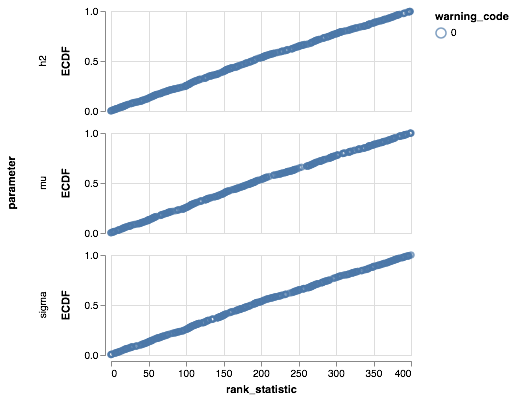

In [19]:
altcat.catplot(data=sbc_output,
               height=100,
               width=300,
               mark='point',
               encoding=dict(x='rank_statistic:Q',
                             y='ECDF:Q',
                             color='warning_code:N',
                             row=alt.Row('parameter:N')),
               transform='ecdf')

First off, we had no sampler issues from the diagnostics, so we're in good shape there. The ECDFs look good at first glance, but we should check to see if any of the deviations from Uniformity are cause for concern. We will therefore plot the relevant parameters in an envelope of ECDFs that contain the (approximate) 99% confidence interval. Instead of plotting the ECDFs, we will plot the difference of the ECDFs from Uniform.

In [20]:
p = bebi103.viz.sbc_rank_ecdf(sbc_output, ['h2', 'mu', 'sigma'], show_legend=True)
bokeh.io.show(p)

Indeed, all look good. We have a one or two points just outside of the 99% envelope, and this is expected when we have 400 samples.

Now, let's look at the shrinkage and z-score.

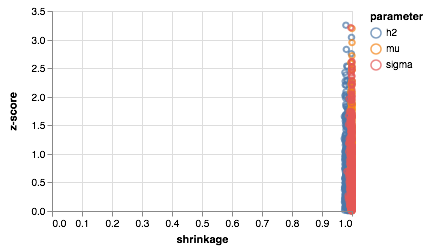

In [21]:
alt.Chart(sbc_output,
        height=200,
        width=300
    ).mark_point(
    ).encode(
        x='shrinkage:Q',
        y=alt.Y('z_score:Q', title='z-score'),
        color='parameter:N'
    )

The small z-scores suggest that the posteriors we are sampling effectively capture the ground truth, and we are seeing large shrinkage, meaning that the data are strongly informing the posterior beyond prior information.

#### Sampling out of the posterior

We have taken steps to validate our modeling, and we are now ready to sample out of the posterior with our real data.

In [22]:
# We do want posterior predictive checks this time
data_post['ppc'] = 1

posterior_samples = sm.sampling(data=data_post)

We can ignore the warnings because they are about the entry in the covariance Cholesky factor that is fixed by construction. Let's run diagnostics on our fit.

In [23]:
bebi103.stan.check_all_diagnostics(posterior_samples, 
                                   known_rhat_nans='L_Sigma[1,2]')

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


0

They look good! Let's look a summary of our samples.

In [24]:
print(posterior_samples.stansummary(pars=['h2', 'mu', 'sigma']))

Inference for Stan model: anon_model_ccc9f8d02b8c18ed7a952c0fbe2eb165.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
h2       0.7  4.7e-4   0.03   0.64   0.68    0.7   0.71   0.74   2960    1.0
mu       9.4  5.9e-4   0.03   9.33   9.37    9.4   9.42   9.46   2897    1.0
sigma   0.69  3.9e-4   0.02   0.65   0.68   0.69   0.71   0.74   2869    1.0

Samples were drawn using NUTS at Wed Oct 10 16:06:06 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In looking at the summary, the 95% credible region for the heritability is $h^2 = 0.70^{+0.4}_{-0.5}$. We could also report the HPD.

In [25]:
bebi103.stan.hpd(posterior_samples.extract('h2')['h2'], 0.95)

array([0.64604624, 0.74405342])

The 95% HPD is similar.

Finally, let's visualize the posterior with a corner plot.

In [26]:
bokeh.io.show(bebi103.viz.corner(posterior_samples, 
                                 vars=['h2', 'mu', 'sigma'], 
                                 alpha=0.1))

This looks good. We see a bit of correlation between the heritability and the variance in the beak length, as we might expect, since the heritability is computed from the variance. These results are commensurate with what we saw in the z-score analysis. We have learned much from the data and these posterior is much sharper than the prior.

As a final check, let's look at our posterior predictive checks. First, we'll plot four samples data sets along with the real one, and then plot all sampled data. For the latter plot, we need to use DataShader, since there are so many points to plot.

In [27]:
# Pull out the PPC data sets
df_ppc = bebi103.stan.extract_array(posterior_samples, 'parent_bd_ppc')
df_ppc['offspring_bd_ppc'] = bebi103.stan.extract_array(
                        posterior_samples, 'offspring_bd_ppc')['offspring_bd_ppc']

# Make four plots, one from each chain
plots = [bokeh.plotting.figure(plot_height=250,
                               plot_width=275,
                               x_axis_label='parental beak depth (mm)',
                               y_axis_label='offspring beak depth (mm)')
          for _ in range(len(df_ppc['chain'].unique()))]
for i in range(len(df_ppc['chain'].unique())):
    inds = (df_ppc['chain'] == i+1) & (df_ppc['chain_idx'] == 1)
    plots[i].circle(df_ppc.loc[inds, 'parent_bd_ppc'], 
                    df_ppc.loc[inds, 'offspring_bd_ppc'],
                    alpha=0.5)
    plots[i].circle(df.loc[:, 'parent_bd'], 
                    df.loc[:, 'offspring_bd'],
                    color='orange',
                    alpha=0.5)

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=2))

And now the plot with all generated data. (This will only work if you have DataShader installed.)

In [28]:
try:
    p = bokeh.plotting.figure(plot_height=350,
                              plot_width=375,
                              x_axis_label='parental beak depth (mm)',
                              y_axis_label='offspring beak depth (mm)',
                              x_range=[6, 13],
                              y_range=[6, 13])
    _ = datashader.bokeh_ext.InteractiveImage(p, 
                                              bebi103.viz._create_points_image, 
                                              df=df_ppc, 
                                              x='parent_bd_ppc', 
                                              y='offspring_bd_ppc',
                                              cmap='blue')
    p.circle(source=df, x='parent_bd', y='offspring_bd', size=2, color='orange')
    bokeh.io.show(p)
except:
    pass

If we look at the plots, it appears as though the real data are slightly lower and to the right compared to the data generated during the posterior predictive checks. This implies that the real parental beak depth is larger than predicted and the offspring beak depth is lower. We can get a clearer picture of this by plotting the ECDFs of the beak lengths and then the  empirical heritability.

In [29]:
# Make plots
p1 = bebi103.viz.predictive_ecdf(posterior_samples, 
                                 'parent_bd_ppc', 
                                 data=df['parent_bd'],
                                 diff=True,
                                 x_axis_label='parent beak depth (mm)')
p2 = bebi103.viz.predictive_ecdf(posterior_samples, 
                                 'offspring_bd_ppc',
                                 data=df['offspring_bd'],
                                 diff=True,
                                 x_axis_label='offspring beak depth (mm)')

p1.x_range = p2.x_range
bokeh.io.show(bokeh.layouts.gridplot([p1, p2], ncols=2))

Indeed, the parent beak depths are larger (ECDF difference is negative) than predicted from the posterior distribution, and the offspring beak depths are smaller. This suggests that the mean beak depth of offspring is different (higher) than that of the parents. We can take a look at the original data.

In looking at the beak depth ECDFs, we see that the posterior predictive data sets miss the ECDFs for the measured data sets. The measured parental beak depth is consistently lower than what is predicted from the posterior. The offspring beak depth is higher. This suggests that the mean beak depth of offspring is different (higher) than that of the parents. We can take a look at the original data.

In [30]:
p = bebi103.viz.ecdf(df['parent_bd'], legend='parent', x_axis_label='beak depth (mm)')
p = bebi103.viz.ecdf(df['offspring_bd'], legend='offspring', color='orange', p=p)
p.legend.location = 'bottom_right'
bokeh.io.show(p)

Indeed, this is born out in the data. We need more flexibility in the model to allow for different mean beak depths. We need to iterate through the process again. We will start with a new generative model wherein we now allow for the parent and offspring to have different mean beak depths.

### Updated model (model version 3)

We again relate the parent and offspring beaks depths via a bivariate Gaussian.
\begin{align}
d_{p,i}, d_{o,i} \mid \boldsymbol{\mu}, \mathsf{\Sigma} \sim \text{MultiNormal}(\boldsymbol{\mu}, \mathsf{\Sigma})\;\;\forall i.
\end{align}

This time, $\boldsymbol{\mu} = (\mu_p, \mu_o)^T$. We finish specifying the model with the remaining priors.

\begin{align}
&\mu_p \sim \text{Normal}(10, 3),\\[1em]
&\mu_o \sim \text{Normal}(10, 3),\\[1em]
&\sigma \sim \text{HalfNormal}(2),\\[1em]
&h_\beta^2 \sim \text{Beta}(5, 2), \\[1em]
&h^2 = 2h_\beta^2 - 1,\\[1em]
&\mathsf{\Sigma} = \sigma^2\begin{pmatrix}
1 & h^2 \\
h^2 & 1
\end{pmatrix}.
\end{align}

Now we can build our generative model, perform checks, and do our inference.

#### Here we go again, prior predictive checks



In [31]:
sm_prior_generative = bebi103.stan.StanModel('t0d_finch_beaks_prior_generative_v03.stan')
print('\n', sm_prior_generative.model_code)

Using cached StanModel.

 functions {
  real heritability(real[] parent, real[] offspring) {
    real parent_var = variance(parent);
    real parent_mean = mean(parent);
    real offspring_mean = mean(offspring);
    int n = size(parent);

    real covariance = 0.0;
    for (i in 1:size(parent)) {
      covariance +=   (parent[i] - parent_mean) 
                    * (offspring[i] - offspring_mean) / n;
    }

    return covariance / parent_var;
  }
}


data {
  // Parameters for priors
  real mu_mean;
  real mu_std;
  real sigma_std;
  real a;
  real b;

  // Size of data set
  int<lower=1> N;
}


generated quantities {
  // Means and variances of univariates
  real mu_parent = normal_rng(mu_mean, mu_std);
  real mu_offspring = normal_rng(mu_mean, mu_std);
  real<lower=0> sigma = fabs(normal_rng(0.0, sigma_std));

  // Heritability
  real h2_beta = beta_rng(a, b);
  real h2 = 2.0 * h2_beta - 1.0;

  // Build Cholesky decomposition of covariance matrix
  matrix[2, 2] L_Sigma = sigma * 

We'll now use our compiled model to generate prior predictions and plot the prior predictive ECDFs, first the ECDFs for the parental and offspring beak depths, and then for the empirical heritability.

In [32]:
prior_check_samples = sm_prior_generative.sampling(data=data_prior_gen, 
                                                   algorithm='Fixed_param', 
                                                   iter=1000, 
                                                   chains=1, 
                                                   warmup=0)

# Make plots
p1 = bebi103.viz.predictive_ecdf(prior_check_samples, 
                                 'parent_bd', 
                                 x_axis_label='parent beak depth (mm)')
p2 = bebi103.viz.predictive_ecdf(prior_check_samples, 
                                 'offspring_bd',
                                 x_axis_label='offspring beak depth (mm)')

p1.x_range = p2.x_range
bokeh.io.show(bokeh.layouts.gridplot([p1, p2], ncols=2))

/Users/Justin/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
p = bebi103.viz.ecdf(prior_check_samples.extract(
                        'empirical_heritability')['empirical_heritability'],
                     x_axis_label='heritability')
bokeh.io.show(p)

These look good, as before. Let's now do our SBC analysis.

#### SBC analyis on version 3

We follow the same procedure for the SBC analysis with the new model. We also expose the updated model code for the posterior.

In [34]:
# Data for posterior sampling (no PPC necessary for now)
data_post = copy.deepcopy(data_prior_gen)
data_post['parent_bd'] = parent_bd
data_post['offspring_bd'] = offspring_bd
data_post['ppc'] = 0

sm = bebi103.stan.StanModel('t0d_finch_beaks_v03.stan')
print('\n', sm.model_code)

Using cached StanModel.

 data {
  // Parameters for priors
  real mu_mean;
  real mu_std;
  real sigma_std;
  real a;
  real b;

  // Data
  int<lower=1> N;
  real parent_bd[N];
  real offspring_bd[N];

  // Do posterior predictive checks?
  int ppc;
}


transformed data {
  vector[2] beak_depths[N];
  for (i in 1:N) {
    beak_depths[i] = [parent_bd[i], offspring_bd[i]]';
  }
}


parameters {
  real mu_parent;
  real mu_offspring;
  real<lower=0> sigma;
  real<lower=0, upper=1> h2_beta;
}


transformed parameters {
  real h2 = 2.0 * h2_beta - 1.0;
  matrix[2, 2] L_Sigma = sigma * [[1.0, 0], 
                                  [h2,  sqrt(1.0 - h2^2)]];  
}


model {
  mu_parent ~ normal(mu_mean, mu_std);
  mu_offspring ~ normal(mu_mean, mu_std);
  sigma ~ normal(0.0, sigma_std);
  h2_beta ~ beta(a, b);

  beak_depths ~ multi_normal_cholesky([mu_parent, mu_offspring]', L_Sigma);
}


generated quantities {
  // Posterior predictive check
  real parent_bd_ppc[N*ppc];
  real offspring_bd_p

Now we perform the simulations to check the model/sampler performance.

In [35]:
try:
    sbc_output = pd.read_csv('sbc_output_v03.csv')
except:
    sbc_output = bebi103.stan.sbc(prior_predictive_model=sm_prior_generative, 
                                  posterior_model=sm, 
                                  prior_predictive_model_data=data_prior_gen, 
                                  posterior_model_data=data_post, 
                                  measured_data=['parent_bd', 'offspring_bd'],
                                  parameters=['mu_parent', 'mu_offspring', 'sigma', 'h2'],
                                  n_jobs=4,
                                  N=400,
                                  progress_bar='notebook')
    sbc_output.to_csv('sbc_output_v03.csv', index=False)

First, we'll check the diagnostics.

In [36]:
sbc_output['warning_code'].sum()

0

The warning codes sum to zero, so we had no issues with divergences, etc. Next, we'll check the rank statistics ECDFs.

In [37]:
p = bebi103.viz.sbc_rank_ecdf(sbc_output, 
                              ['h2', 'mu_parent', 'mu_offspring', 'sigma'], 
                              show_legend=True)
bokeh.io.show(p)

No problems there. And finally, let's check the z-scores and shrinkage.

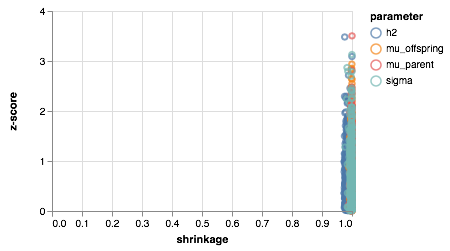

In [38]:
alt.Chart(sbc_output,
        height=200,
        width=300
    ).mark_point(
    ).encode(
        x='shrinkage:Q',
        y=alt.Y('z_score:Q', title='z-score'),
        color='parameter:N'
    )

Here, everything looks good as well.

#### Sampling out of the posterior

Our model and sampler look ok, so let's sample out of the posterior.

In [39]:
# We do want posterior predictive checks this time
data_post['ppc'] = 1

posterior_samples_v03 = sm.sampling(data=data_post)

We can again ignore the warnings because they are about a fixed entry in the Cholesky matrix. Let's check the diagnostics to make sure we sampled ok.

In [40]:
bebi103.stan.check_all_diagnostics(posterior_samples_v03, known_rhat_nans='L_Sigma[1,2]')

n_eff / iter looks reasonable for all parameters.
Rhat for parameter L_Sigma[0,1] is nan.
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 (0.0%) iterations ended with a divergence.
0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


2

The diagnostics look good. Now we can check the posterior predictive distribution. First, we'll make a scatter plot, as we did when evaluating the previous model. (Again, this will only work if DataShader is installed.)

In [41]:
try:
    # Pull out the PPC data sets
    df_ppc = bebi103.stan.extract_array(posterior_samples, 'parent_bd_ppc')
    df_ppc['offspring_bd_ppc'] = bebi103.stan.extract_array(
                            posterior_samples, 'offspring_bd_ppc')['offspring_bd_ppc']

    p = bokeh.plotting.figure(plot_height=350,
                              plot_width=375,
                              x_axis_label='parental beak depth (mm)',
                              y_axis_label='offspring beak depth (mm)',
                              x_range=[6, 13],
                              y_range=[6, 13])
    _ = datashader.bokeh_ext.InteractiveImage(p, 
                                              bebi103.viz._create_points_image, 
                                              df=df_ppc, 
                                              x='parent_bd_ppc', 
                                              y='offspring_bd_ppc',
                                              cmap='blue')
    p.circle(source=df, x='parent_bd', y='offspring_bd', size=2, color='orange')
    bokeh.io.show(p)
except:
    pass

This looks better than before. Let's check the predictive ECDFs.

In [42]:
# Make plots
p1 = bebi103.viz.predictive_ecdf(posterior_samples_v03, 
                                 'parent_bd_ppc',
                                 data=df['parent_bd'],
                                 diff=True,
                                 x_axis_label='parent beak depth (mm)')

p2 = bebi103.viz.predictive_ecdf(posterior_samples_v03, 
                                 'offspring_bd_ppc',
                                 data=df['offspring_bd'],
                                 diff=True,
                                 x_axis_label='offspring beak depth (mm)')

p1.x_range = p2.x_range
bokeh.io.show(bokeh.layouts.gridplot([p1, p2], ncols=2))

The deviation from the posterior predictive distribution occurs primarily at the tails (there is an occasional point of the ECDF that goes outside the 90th percentile of the posterior predictive samples, but this is expected). This is likely due to deviations from Gaussianity for very shallow or very deep beaks. 

We will move forward and look at the posterior distribution in a corner plot.

In [43]:
bokeh.io.show(bebi103.viz.corner(posterior_samples_v03, 
                    vars=['h2', 'mu_parent', 'mu_offspring', 'sigma'], 
                    alpha=0.1))

The heritability parameter has shifted rightward compared to our earlier modeling effort. Let's look at a summary.

In [44]:
print(posterior_samples_v03.stansummary(
            pars=['h2', 'mu_parent', 'mu_offspring', 'sigma']))

Inference for Stan model: anon_model_4f9fabb9c335276d7e94ff8e9e367a6b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
h2             0.72  4.8e-4   0.02   0.67   0.71   0.73   0.74   0.77   2583    1.0
mu_parent      9.48  7.6e-4   0.03   9.41   9.46   9.48   9.51   9.55   2101    1.0
mu_offspring    9.3  6.8e-4   0.03   9.23   9.28    9.3   9.33   9.37   2551    1.0
sigma          0.69  4.1e-4   0.02   0.65   0.67   0.69    0.7   0.73   2624    1.0

Samples were drawn using NUTS at Wed Oct 10 16:07:12 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We report $h^2 = 0.73^{+0.4}_{-0.5}$.

## Computing environment

In [45]:
%load_ext watermark

In [46]:
%watermark -v -p numpy,scipy,pandas,pystan,bokeh,datashader,altair,altair_catplot,bebi103,jupyterlab

CPython 3.7.0
IPython 7.0.1

numpy 1.15.2
scipy 1.1.0
pandas 0.23.4
pystan 2.17.1.0
bokeh 0.13.0
datashader 0.6.8
altair 2.2.2
altair_catplot 0.0.3
bebi103 0.0.25
jupyterlab 0.35.0
